## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import numpy as np
from sklearn.metrics import recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

В этом примере мы попробуем предсказать итоговую оценку участинка только на основе **его действий**

In [2]:
df_train = pd.read_csv("train.csv")
df_user = pd.read_csv("user_decision.csv")

## Рассмотрим датасет по ближе

In [3]:
df_train.shape


(680, 5)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   680 non-null    int64  
 1   Analytical thinking  680 non-null    float64
 2   Systemic thinking    680 non-null    float64
 3   Adaptability         680 non-null    float64
 4   Focus                680 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 26.7 KB


In [5]:
df_train.head(30)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10884,4.0,4.0,4.0,4.0
1,10106,5.0,4.0,5.0,5.0
2,10438,6.0,5.0,5.0,5.0
3,10130,5.0,4.0,5.0,5.0
4,10667,4.0,5.0,5.0,5.0
5,10908,4.0,4.0,5.0,5.0
6,10378,4.0,5.0,5.0,4.0
7,10220,5.0,4.0,5.0,5.0
8,10612,5.0,4.0,4.0,5.0
9,10776,4.0,4.0,5.0,5.0


In [6]:
df_user.shape

(60228, 3)

In [7]:
df_user.head(3)

,user_id,period,decision_id
0,10625,1,409
1,10318,3,203
2,10775,4,420


In [8]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60228 entries, 0 to 60227
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      60228 non-null  int64
 1   period       60228 non-null  int64
 2   decision_id  60228 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


Заметим что в есть категория где пользватель совершал больше действий

In [9]:
df_user.period.value_counts()

3    20964
4    14811
2    14453
1    10000
Name: period, dtype: int64

Пострим на распределение данных

Text(0.5, 1.0, 'Распределение периода')

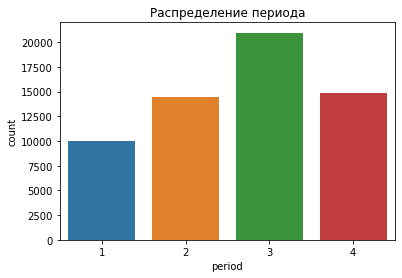

In [10]:
sns.countplot(x = "period" , data  = df_user).set_title('Распределение периода')

Text(0.5, 1.0, 'Распределение действий')

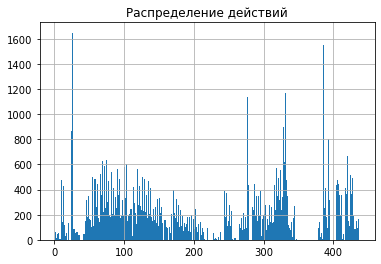

In [11]:
df_user["decision_id"].hist(bins = 300).set_title('Распределение действий')

sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = df_user, x= "decision_id", y = "period").set_title('Зависимость действий от игровго периода')

### Добавим новых значений

Узнаем частоту команд участника в каждом периоде

In [12]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in df_train.id.values)]

In [13]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [14]:
df_decision_count.head(5)

decision_id
user_id period             
10001   1                29
        2                23
        3                39
        4                15
10003   1                21

In [15]:
for id in df_train.id.values:
  for period in range(1,5):
    try :
      index = df_train[df_train.id == id].index[0]
      df_train.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [16]:
df_train.head(3)

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0


In [17]:

df_train['Adaptability'].value_counts()

5.0    318
4.0    308
3.0     36
6.0     15
1.0      2
2.0      1
Name: Adaptability, dtype: int64

In [18]:
Xnorm = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1).fillna(0, inplace=True)
ynorm = df_train['Analytical thinking'].fillna(0, inplace=True)

focus1=df_train.query("Adaptability==2").head()
focus2=df_train.query("Adaptability==1").head()
focus3=df_train.query("Adaptability==6").head()
for i in range(1,100):
    df_train=df_train.append(focus1, ignore_index=True)
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)

In [19]:
df_train['Adaptability'].value_counts()

5.0    318
4.0    308
3.0     36
6.0     15
1.0      2
2.0      1
Name: Adaptability, dtype: int64

In [20]:
df_train['Focus'].value_counts()

4.0    400
5.0    244
3.0     29
6.0      3
1.0      3
2.0      1
Name: Focus, dtype: int64

focus1=df_train.query("Adaptability==2").head()
focus2=df_train.query("Adaptability==1").head()
focus3=df_train.query("Focus==6").head(3)
for i in range(1,6):
    df_train=df_train.append(focus1, ignore_index=True)
    df_train=df_train.append(focus2, ignore_index=True)
    df_train=df_train.append(focus3, ignore_index=True)

df_train['period_1'].fillna(df_train['period_1'].median(), inplace=True)
df_train['period_2'].fillna(df_train['period_2'].median(), inplace=True)
df_train['period_3'].fillna(df_train['period_3'].median(), inplace=True)
df_train['period_4'].fillna(df_train['period_4'].median(), inplace=True)

In [21]:
df_train['period_1'].fillna(df_train['period_1'].median(), inplace=True)
df_train['period_2'].fillna(df_train['period_2'].median(), inplace=True)
df_train['period_3'].fillna(df_train['period_3'].median(), inplace=True)
df_train['period_4'].fillna(df_train['period_4'].median(), inplace=True)

In [22]:
df_train.isna().sum()

id                     0
Analytical thinking    0
Systemic thinking      0
Adaptability           0
Focus                  0
period_1               0
period_2               0
period_3               0
period_4               0
dtype: int64

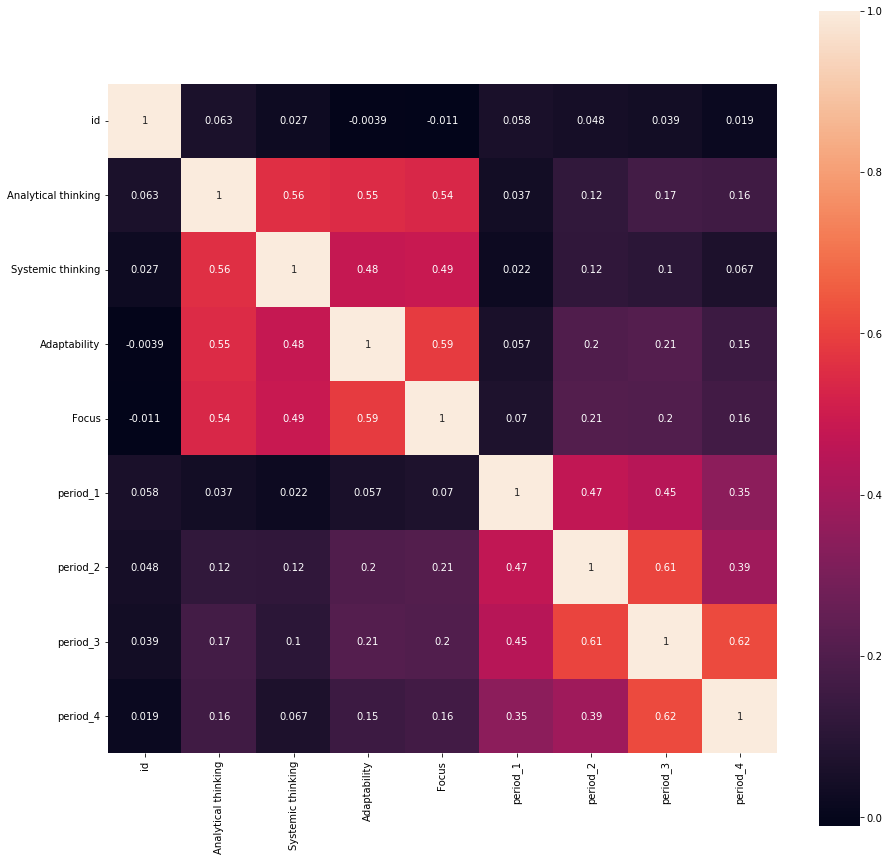

In [23]:
plt.rcParams['figure.figsize']=(15,15)

g = sns.heatmap(df_train.corr(), square = True, annot=True)

In [24]:
df_train

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10884,4.0,4.0,4.0,4.0,7.0,14.0,28.0,10.0
1,10106,5.0,4.0,5.0,5.0,21.0,21.0,12.0,8.0
2,10438,6.0,5.0,5.0,5.0,62.0,45.0,63.0,38.0
3,10130,5.0,4.0,5.0,5.0,26.0,28.0,34.0,66.0
4,10667,4.0,5.0,5.0,5.0,58.0,70.0,194.0,35.0
...,...,...,...,...,...,...,...,...,...
675,10563,5.0,4.0,5.0,4.0,10.0,2.0,14.0,4.0
676,10386,5.0,4.0,5.0,5.0,1.0,14.0,24.0,1.0
677,10675,5.0,4.0,5.0,4.0,4.0,17.0,23.0,12.0
678,10366,4.0,4.0,4.0,4.0,10.0,44.0,45.0,38.0


In [25]:
df_train.to_csv('df_train.csv',index=False)

## Выделим выборки

In [26]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Analytical thinking']
Xnorm = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
ynorm = df_train['Analytical thinking']

In [27]:
X.shape

(680, 4)

In [28]:
X

,period_1,period_2,period_3,period_4
0,7.0,14.0,28.0,10.0
1,21.0,21.0,12.0,8.0
2,62.0,45.0,63.0,38.0
3,26.0,28.0,34.0,66.0
4,58.0,70.0,194.0,35.0
...,...,...,...,...
675,10.0,2.0,14.0,4.0
676,1.0,14.0,24.0,1.0
677,4.0,17.0,23.0,12.0
678,10.0,44.0,45.0,38.0


In [29]:
y

0      4.0
1      5.0
2      6.0
3      5.0
4      4.0
      ... 
675    5.0
676    5.0
677    5.0
678    4.0
679    4.0
Name: Analytical thinking, Length: 680, dtype: float64

In [30]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)
X_trainx, X_testx, y_trainx, y_testx = train_test_split( X_train, y_train, test_size=0.3, random_state=42)

## Обучение модели

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
rf_model_Analytical_thinking =  RandomForestClassifier(max_depth=11,min_samples_leaf=1,min_samples_split=8,n_estimators=40) # Ваш код здесь
# обучим модель случайного леса
rf_model_Analytical_thinking.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, min_samples_split=8, n_estimators=40)

from sklearn.metrics import accuracy_score# подбор количества соседей.
for i in range(1,100):
    rft_model_Analytical_thinking =  KNeighborsClassifier(n_neighbors=i) # Ваш код здесь
# обучим модель случайного леса
    rft_model_Analytical_thinking.fit(X_train, y_train)
    pred = rft_model_Analytical_thinking.predict(X_test)
    print(i,accuracy_score(y_test, pred))

rf_model =  RandomForestClassifier(n_jobs=-1)
from sklearn.model_selection import GridSearchCV
parametrs = { 'n_estimators': range (10, 51, 5),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(rf_model, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

## Оценка точности

In [32]:
pred = rf_model_Analytical_thinking.predict(X_test)

In [33]:
from sklearn.metrics import classification_report
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00        13
         4.0       0.60      0.90      0.72       119
         5.0       0.42      0.17      0.24        66
         6.0       0.00      0.00      0.00         6

    accuracy                           0.58       204
   macro avg       0.26      0.27      0.24       204
weighted avg       0.49      0.58      0.50       204



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:

X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Systemic thinking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model_Systemic_thinking = RandomForestClassifier(max_depth=11,min_samples_leaf=6,min_samples_split=4,n_estimators=20) # Ваш код здесь
# обучим модель случайного леса
rf_model_Systemic_thinking.fit(X_train, y_train)
pred = rf_model_Systemic_thinking.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00        21
         4.0       0.70      0.99      0.82       142
         5.0       0.50      0.03      0.05        39
         6.0       0.00      0.00      0.00         2

    accuracy                           0.70       204
   macro avg       0.30      0.25      0.22       204
weighted avg       0.58      0.70      0.58       204



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf_model =  RandomForestClassifier(n_jobs=-1)
from sklearn.model_selection import GridSearchCV
parametrs = { 'n_estimators': range (10, 51, 5),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(rf_model, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

In [35]:
X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Adaptability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model_Adaptability =  RandomForestClassifier(max_depth=11,min_samples_leaf=7,min_samples_split=2,n_estimators=20) # Ваш код здесь
# обучим модель случайного леса
rf_model_Adaptability.fit(X_train, y_train)
pred = rf_model_Adaptability.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00        13
         4.0       0.47      0.44      0.45        91
         5.0       0.51      0.65      0.57        93
         6.0       0.00      0.00      0.00         6

    accuracy                           0.49       204
   macro avg       0.19      0.22      0.20       204
weighted avg       0.44      0.49      0.46       204



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf_model =  RandomForestClassifier(n_jobs=-1)
from sklearn.model_selection import GridSearchCV
parametrs = { 'n_estimators': range (10, 51, 5),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(rf_model, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

In [36]:

X = df_train.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
y = df_train['Focus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model_Focus =  RandomForestClassifier(max_depth=11,min_samples_leaf=5,min_samples_split=6,n_estimators=30) # Ваш код здесь
# обучим модель случайного леса
rf_model_Focus.fit(X_train, y_train)
pred = rf_model_Focus.predict(X_test)
print (classification_report(y_test, pred))

              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00        10
         4.0       0.59      0.77      0.67       117
         5.0       0.46      0.32      0.37        76

    accuracy                           0.56       204
   macro avg       0.26      0.27      0.26       204
weighted avg       0.51      0.56      0.52       204



/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gennalll/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf_model =  RandomForestClassifier(n_jobs=-1)
from sklearn.model_selection import GridSearchCV
parametrs = { 'n_estimators': range (10, 51, 5),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(rf_model, parametrs, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_params_

In [37]:
# Предикт.

In [38]:
datapre=pd.read_csv('sample_solution.csv')

In [39]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [40]:
df_user_train = df_user[df_user.user_id.map(lambda x:x in datapre.id.values)]

In [41]:
df_decision_count = df_user_train.groupby(by=["user_id",	"period"]).count()

In [42]:
df_decision_count.head(5)

decision_id
user_id period             
10002   2                 9
        3                25
        4                22
10005   1                14
        2                34

In [43]:
for id in datapre.id.values:
  for period in range(1,5):
    try :
      index = datapre[datapre.id == id].index[0]
      datapre.loc[index,"period_"+str(period)] = df_decision_count.loc[pd.IndexSlice[id, period:period], :].values[0][0]
    except IndexError:
      continue

In [44]:
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10199,0,0,0,0,2.0,2.0,3.0,2.0
1,10539,0,0,0,0,1.0,9.0,15.0,17.0
2,10174,0,0,0,0,NaN,28.0,31.0,20.0
3,10465,0,0,0,0,15.0,18.0,32.0,18.0
4,10066,0,0,0,0,8.0,23.0,16.0,6.0
...,...,...,...,...,...,...,...,...,...
288,10433,0,0,0,0,18.0,7.0,1.0,NaN
289,10893,0,0,0,0,21.0,52.0,34.0,20.0
290,10909,0,0,0,0,NaN,NaN,NaN,1.0
291,10889,0,0,0,0,6.0,2.0,5.0,1.0


In [45]:
datapre['period_1'].fillna(datapre['period_1'].median(), inplace=True)
datapre['period_2'].fillna(datapre['period_2'].median(), inplace=True)
datapre['period_3'].fillna(datapre['period_3'].median(), inplace=True)
datapre['period_4'].fillna(datapre['period_4'].median(), inplace=True)
datapre

,id,Analytical thinking,Systemic thinking,Adaptability,Focus,period_1,period_2,period_3,period_4
0,10199,0,0,0,0,2.0,2.0,3.0,2.0
1,10539,0,0,0,0,1.0,9.0,15.0,17.0
2,10174,0,0,0,0,9.0,28.0,31.0,20.0
3,10465,0,0,0,0,15.0,18.0,32.0,18.0
4,10066,0,0,0,0,8.0,23.0,16.0,6.0
...,...,...,...,...,...,...,...,...,...
288,10433,0,0,0,0,18.0,7.0,1.0,12.0
289,10893,0,0,0,0,21.0,52.0,34.0,20.0
290,10909,0,0,0,0,9.0,12.0,17.0,1.0
291,10889,0,0,0,0,6.0,2.0,5.0,1.0


In [46]:
datapre.to_csv('datapretest.csv',index=False)

In [47]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Analytical_thinking = rf_model_Analytical_thinking.predict(X)
pred_Analytical_thinking

array([4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4., 5., 5., 5.,
       4., 5., 4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 5., 4., 5., 5., 4., 4.,
       5., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 5., 4., 4., 5.,
       4., 4., 4., 5., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 4.,
       4., 4., 4., 5., 4., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4., 4., 5., 4., 4., 4.,
       4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4.,
       4., 4., 4., 4., 4.

In [48]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Systemic_thinking = rf_model_Systemic_thinking.predict(X)
pred_Systemic_thinking

array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

In [49]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Adaptability = rf_model_Adaptability.predict(X)
pred_Adaptability

array([4., 4., 5., 5., 5., 4., 5., 5., 4., 4., 4., 5., 5., 5., 4., 4., 5.,
       5., 5., 5., 5., 5., 4., 4., 4., 5., 4., 4., 4., 4., 5., 4., 4., 5.,
       5., 5., 5., 4., 5., 4., 5., 5., 4., 5., 5., 5., 5., 4., 4., 4., 5.,
       4., 5., 4., 4., 5., 4., 4., 5., 5., 5., 5., 5., 4., 5., 4., 5., 5.,
       4., 5., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 5., 5., 5., 4., 4.,
       4., 5., 4., 5., 4., 5., 5., 4., 4., 5., 5., 5., 5., 5., 5., 5., 4.,
       5., 4., 5., 4., 4., 5., 4., 5., 4., 5., 5., 5., 4., 5., 5., 5., 5.,
       5., 5., 4., 5., 4., 5., 5., 5., 4., 5., 4., 5., 4., 5., 4., 5., 4.,
       4., 4., 4., 4., 5., 4., 4., 5., 5., 4., 5., 5., 4., 4., 5., 5., 4.,
       4., 4., 5., 5., 4., 5., 5., 4., 5., 4., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 4., 4., 5., 5., 4., 4., 5., 5., 5., 4., 5., 5., 5., 5., 5.,
       4., 5., 5., 4., 4., 5., 5., 4., 4., 4., 4., 4., 4., 5., 5., 5., 5.,
       5., 5., 5., 5., 4., 5., 4., 4., 5., 4., 4., 5., 5., 5., 5., 5., 5.,
       4., 4., 4., 5., 5.

In [50]:
X = datapre.drop(['Analytical thinking','Systemic thinking','Adaptability', 'Focus','id'], axis = 1)
pred_Focus = rf_model_Focus.predict(X)
len(pred_Focus)

293

In [51]:
datapre=pd.read_csv('sample_solution.csv')
datapre  

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,0,0,0,0
1,10539,0,0,0,0
2,10174,0,0,0,0
3,10465,0,0,0,0
4,10066,0,0,0,0
...,...,...,...,...,...
288,10433,0,0,0,0
289,10893,0,0,0,0
290,10909,0,0,0,0
291,10889,0,0,0,0


In [52]:
datapre['Analytical thinking']=pred_Analytical_thinking
datapre['Systemic thinking']=pred_Systemic_thinking
datapre['Adaptability']=pred_Adaptability
datapre['Focus']=pred_Focus

In [53]:
datapre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   293 non-null    int64  
 1   Analytical thinking  293 non-null    float64
 2   Systemic thinking    293 non-null    float64
 3   Adaptability         293 non-null    float64
 4   Focus                293 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 11.6 KB


In [54]:
datapre.to_csv('dataprerf6.csv',index=False)

In [55]:
dataprev=pd.read_csv('dataprerf6.csv')

In [56]:
dataprev

,id,Analytical thinking,Systemic thinking,Adaptability,Focus
0,10199,4.0,4.0,4.0,4.0
1,10539,4.0,4.0,4.0,4.0
2,10174,4.0,4.0,5.0,5.0
3,10465,4.0,4.0,5.0,5.0
4,10066,4.0,4.0,5.0,4.0
...,...,...,...,...,...
288,10433,4.0,4.0,4.0,4.0
289,10893,4.0,4.0,5.0,5.0
290,10909,4.0,4.0,5.0,4.0
291,10889,4.0,4.0,4.0,4.0


In [57]:
dataprev['Analytical thinking'].value_counts()

4.0    245
5.0     48
Name: Analytical thinking, dtype: int64